## Setup environment

In [1]:
!pip install numpy==1.19.5 six==1.15.0 typing-extensions==3.7.4 wrapt==1.12.1 pyarrow<6 absl-py<0.13
!pip install monai gdown einops mlflow pynrrd torchinfo


/bin/bash: 6: No such file or directory
     |████████████████████████████████| 1.2 MB 9.9 MB/s            
     |████████████████████████████████| 42 kB 964 kB/s             
     |████████████████████████████████| 17.0 MB 60.0 MB/s            
     |████████████████████████████████| 150 kB 62.6 MB/s            
     |████████████████████████████████| 79 kB 8.2 MB/s             
     |████████████████████████████████| 15.7 MB 55.5 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not

In [3]:
!pip -q install monai gdown einops mlflow pynrrd torchinfo 

In [4]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [6]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    FillHoles,
    LoadImaged,
    Orientationd,
    OneOf,
    RandCropByPosNegLabeld,
    RandAffined,
    RandGaussianSmoothd,
    RandFlipd,
    Resized,
    RemoveSmallObjects,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric,HausdorffDistanceMetric
from monai.losses import DiceLoss,DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np

## Setup imports

In [ ]:



print_config()

MONAI version: 1.1.0
Numpy version: 1.19.5
Pytorch version: 1.9.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /opt/conda/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.7
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.2.0
Tensorboard version: 2.6.0
gdown version: 4.7.3
TorchVision version: 0.10.1
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.4
einops version: 0.6.1
transformers version: 4.12.5
mlflow version: 1.30.1
pynrrd version: 1.1.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [8]:
set_determinism(seed=123)

In [8]:
directory = '/kaggle/input/spleenct'
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)
root2_dir = '/kaggle/working/'

/kaggle/input/spleenct


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [9]:

resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
print(data_dir)
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

/kaggle/input/spleenct/Task09_Spleen


## Set MSD Spleen dataset path

In [10]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
# train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [11]:

import random
x=[i for i in range(41)]
print(x)
random.shuffle(x)
print(x)
train_index,val_index,test_index=x[:33],x[33:],x[33:]
train_files=[]
val_files=[]
test_files=[]
for i in train_index:
    train_files.append(data_dicts[i])
for i in val_index:
    val_files.append(data_dicts[i])
for i in test_index:
    test_files.append(data_dicts[i])
 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
[14, 9, 30, 40, 25, 33, 35, 8, 16, 19, 15, 29, 23, 11, 31, 20, 18, 12, 34, 13, 0, 28, 7, 22, 37, 36, 10, 4, 38, 1, 27, 32, 21, 24, 2, 6, 39, 26, 5, 17, 3]


## Set deterministic training for reproducibility

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.
1. `EnsureTyped` converts the numpy array to PyTorch Tensor for further steps.

In [12]:
newsize=(128,128,-1)
cropsize=(96,96,96)
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Resized(keys=["image", "label"],spatial_size=newsize),

#         OneOf(
#             transforms=[
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=0.5, spatial_size=(-1, -1, -1),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
        RandFlipd(
            keys=['image', 'label'],
            prob=0.5, 
            spatial_axis=1,
            ),
#         RandGaussianSmoothd(
#             keys=['image', 'label'],
#             prob=0.4,),


#             ]
            
#         ),    
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=cropsize,
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
   
        # user can also add other random transforms

        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Resized(keys=["image", "label"],spatial_size=newsize),
        EnsureTyped(keys=["image", "label"]),
    ]
)

## Check transforms in DataLoader

torch.Size([4, 1, 96, 96, 96])
image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


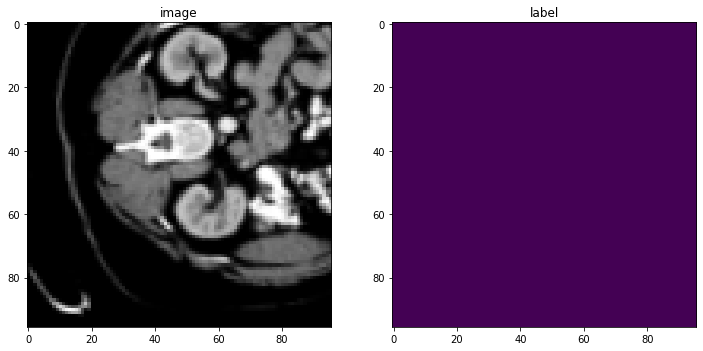

In [13]:
check_ds = Dataset(data=val_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
for check_data in check_loader:
    print(check_data['image'].shape)
    break
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 70], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 70])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [14]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)
test_ds =Dataset(
    data=test_files, transform=val_transforms)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 8/8 [00:16<00:00,  2.02s/it]


## Create Model, Loss, Optimizer

In [15]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(32, 64, 128, 256,512),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), 1e-4,weight_decay=1e-5)
dice_metric = DiceMetric(include_background=False, reduction="mean")
hd95_metric=HausdorffDistanceMetric(include_background=False, reduction="mean",percentile=95)

## Execute a typical PyTorch training process

In [16]:
max_epochs = 400
val_interval = 4
best_metric = -1
best_metric_epoch = -1
best_metric2 = -1
best_metric2_epoch = -1
epoch_loss_values = []
metric_values = []
metric2_values = []

post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])

post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
            
        )
#         print(inputs.shape)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
#         print(
#             f"{step}/{len(train_ds) // train_loader.batch_size}, "
#             f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
#             
                roi_size = cropsize
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
#                 print('1',val_outputs.shape)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
#                 print('2',val_outputs[0].shape) 
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
                hd95_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            metric2=hd95_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()
            hd95_metric.reset()

            metric_values.append(metric)
            metric2_values.append(metric2)
            if metric > best_metric:
                best_metric = metric
                best_metric2=metric2
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root2_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f},hd:{best_metric2:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/400
epoch 1 average loss: 1.1769
----------
epoch 2/400
epoch 2 average loss: 1.0874
----------
epoch 3/400
epoch 3 average loss: 1.0398
----------
epoch 4/400
epoch 4 average loss: 1.0011
saved new best metric model
current epoch: 4 current mean dice: 0.3782
best mean dice: 0.3782,hd:101.5182 at epoch: 4
----------
epoch 5/400
epoch 5 average loss: 0.9673
----------
epoch 6/400
epoch 6 average loss: 0.9375
----------
epoch 7/400
epoch 7 average loss: 0.9075
----------
epoch 8/400
epoch 8 average loss: 0.8807
saved new best metric model
current epoch: 8 current mean dice: 0.5573
best mean dice: 0.5573,hd:92.2045 at epoch: 8
----------
epoch 9/400
epoch 9 average loss: 0.8530
----------
epoch 10/400
epoch 10 average loss: 0.8249
----------
epoch 11/400
epoch 11 average loss: 0.7978
----------
epoch 12/400
epoch 12 average loss: 0.7770
saved new best metric model
current epoch: 12 current mean dice: 0.7195
best mean dice: 0.7195,hd:36.7722 at epoch: 12
----------
epoch

/opt/conda/lib/python3.7/site-packages/monai/metrics/hausdorff_distance.py:170: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")


current epoch: 132 current mean dice: 0.6768
best mean dice: 0.9285,hd:2.5195 at epoch: 124
----------
epoch 133/400
epoch 133 average loss: 0.1286
----------
epoch 134/400
epoch 134 average loss: 0.1436
----------
epoch 135/400
epoch 135 average loss: 0.1446
----------
epoch 136/400
epoch 136 average loss: 0.1501
current epoch: 136 current mean dice: 0.8204
best mean dice: 0.9285,hd:2.5195 at epoch: 124
----------
epoch 137/400
epoch 137 average loss: 0.1476
----------
epoch 138/400
epoch 138 average loss: 0.1214
----------
epoch 139/400
epoch 139 average loss: 0.1092
----------
epoch 140/400
epoch 140 average loss: 0.1212
current epoch: 140 current mean dice: 0.8175
best mean dice: 0.9285,hd:2.5195 at epoch: 124
----------
epoch 141/400
epoch 141 average loss: 0.0970
----------
epoch 142/400
epoch 142 average loss: 0.1098
----------
epoch 143/400
epoch 143 average loss: 0.1157
----------
epoch 144/400
epoch 144 average loss: 0.1117
current epoch: 144 current mean dice: 0.8766
best me

In [17]:
print(
    f"train completed, best_metric: {best_metric:.4f} ,best_hd:{best_metric2:.4f}"
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.9429 ,best_hd:1.2348at epoch: 336


## Plot the loss and metric

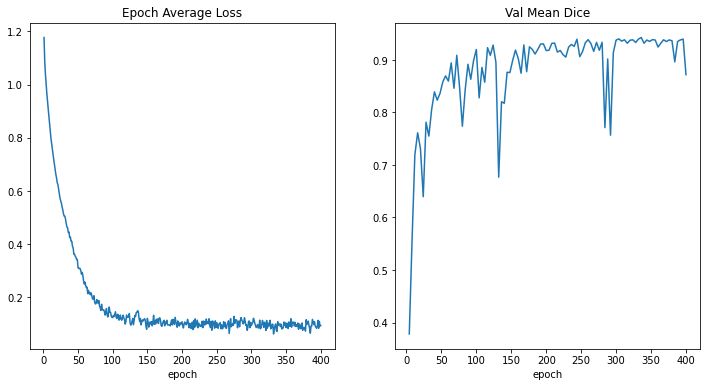

In [19]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

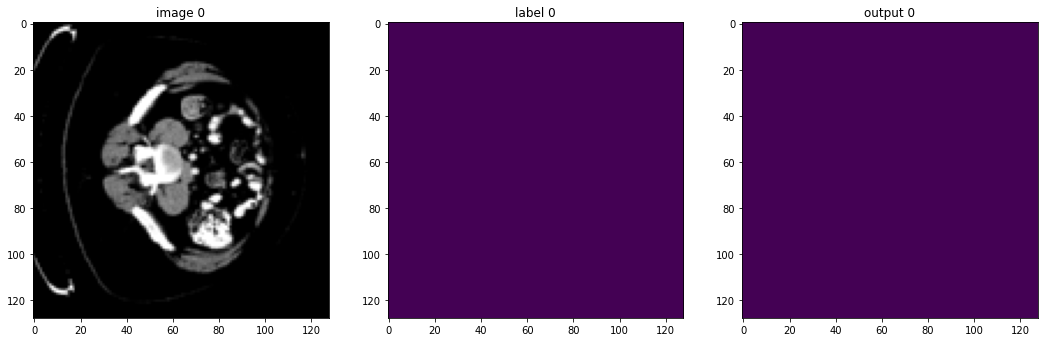

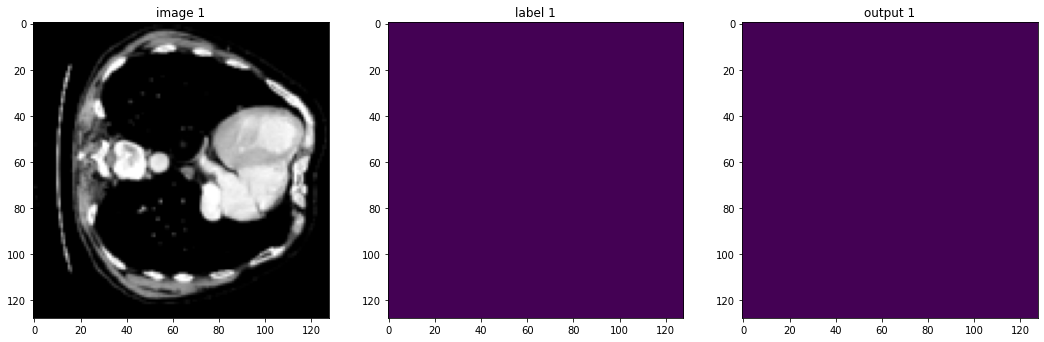

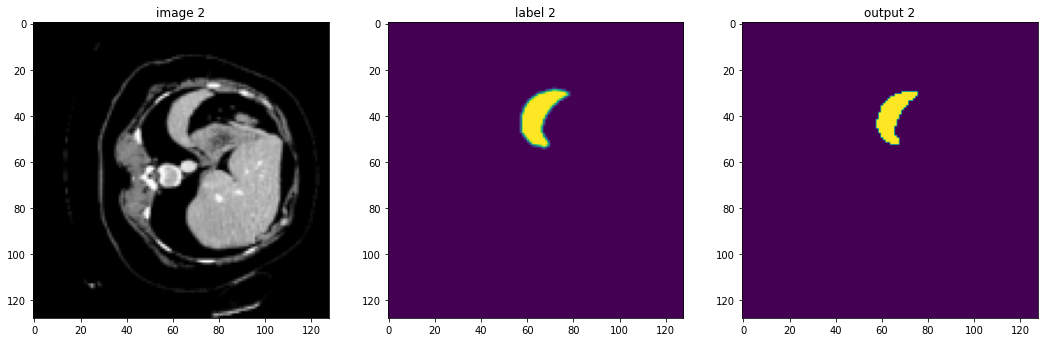

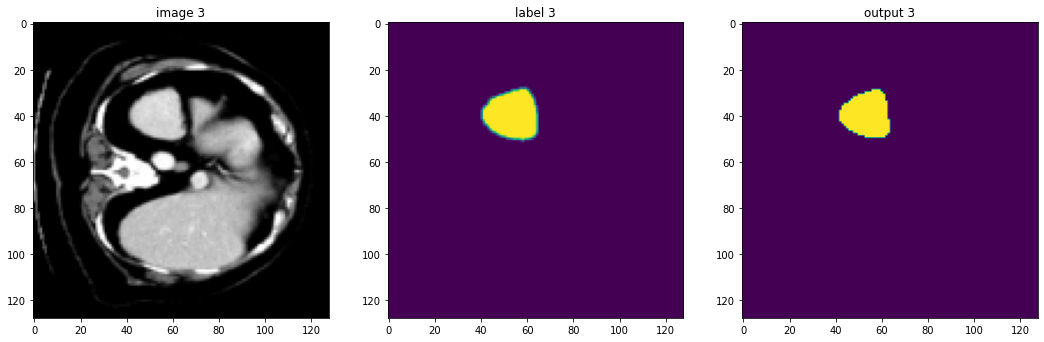

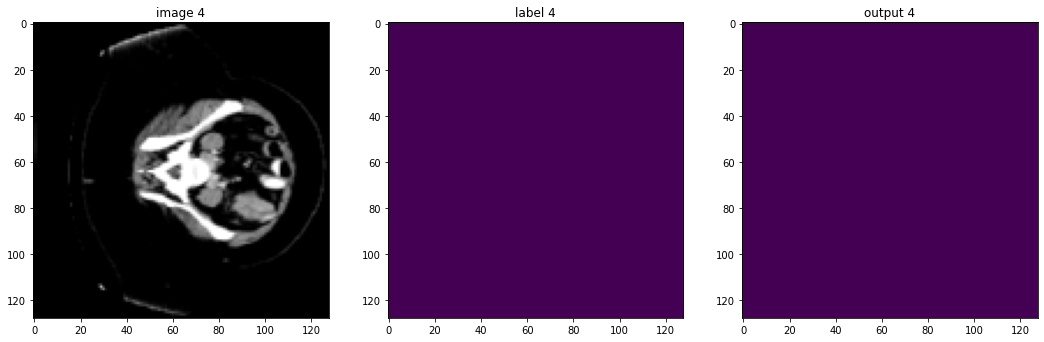

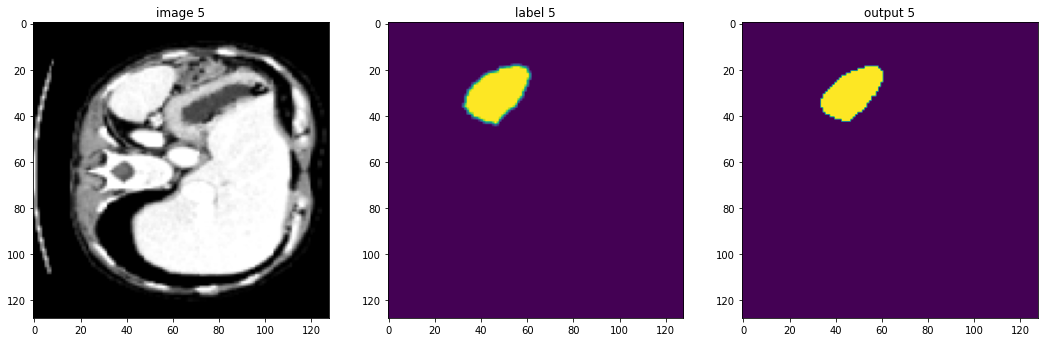

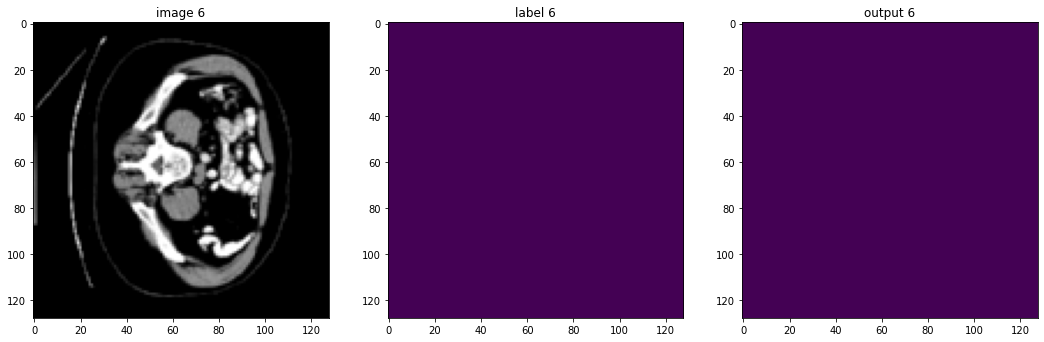

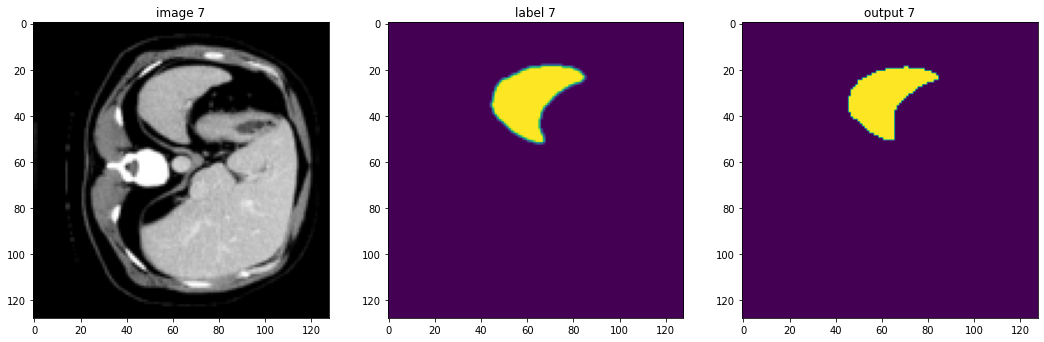

In [20]:
model.load_state_dict(torch.load(
    os.path.join(root2_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = cropsize
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 90], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 90])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 90])
        plt.show()
        if i == 7:
            break

## Evaluation on test data

In [21]:
post_pred_val=Compose([
    EnsureType(), 
    FillHoles(),
    
    AsDiscrete(argmax=True, to_onehot=2),
    RemoveSmallObjects(min_size=64),
])
model.load_state_dict(torch.load(
    os.path.join(root2_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_labels = test_data["label"].to(device)
#         print(test_inputs.shape,test_labels.shape)
        roi_size = cropsize
        sw_batch_size = 4
        test_outputs = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model)
        test_outputs = [post_pred_val(i) for i in decollate_batch(test_outputs)]
        test_labels = [post_label(i) for i in decollate_batch(test_labels)]
#                
        # compute metric for current iteration
#         val_outputs.to(device)
#         val_labels.to(device)
        dice_metric(y_pred=test_outputs, y=test_labels)
        hd95_metric(y_pred=test_outputs, y=test_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    metric_hd = hd95_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()
    hd95_metric.reset()


print("Metric on test data: ", metric_org,metric_hd)

Metric on test data:  0.9432588815689087 1.1950597415393833


In [10]:
import torch
import numpy as np
from monai.inferers import sliding_window_inference

# 1. Load your trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("/kaggle/working/best_metric_model.pth", map_location=device))
model.to(device)
model.eval()

# 2. A small helper to compute IoU per volume
def compute_iou(pred: torch.Tensor, label: torch.Tensor):
    """
    pred, label: binary tensors, shape (H,W,D) or (1,H,W,D)
    returns IoU = |pred ∩ label| / |pred ∪ label|
    """
    # ensure binary
    pred = (pred > 0).float()
    label = (label > 0).float()
    intersection = torch.sum(pred * label)
    union = torch.sum(pred) + torch.sum(label) - intersection
    # avoid zero division
    if union == 0:
        return torch.tensor(1.0 if intersection == 0 else 0.0)
    return intersection / union

# 3. Run inference and accumulate IoUs
ious = []
with torch.no_grad():
    for batch in test_loader:
        # batch['image'] shape: (1, C, H, W, D)
        # batch['label'] shape: (1, C_label=1, H, W, D) or (1, H, W, D)
        img = batch["image"].to(device)
        lbl = batch["label"].to(device)
        # get raw logits or soft probabilities
        output = sliding_window_inference(
            inputs=img,
            roi_size=(96, 96, 96),   # adjust to match your training
            sw_batch_size=4,
            predictor=model,
        )
        # convert to binary prediction: argmax over channel dim if multi-class
        # if your network outputs two channels (background vs spleen):
        pred = torch.argmax(output, dim=1, keepdim=False)  # shape (1,H,W,D)
        # if your output is single-channel probability, threshold at 0.5:
        # pred = (output > 0.5).float().squeeze(1)

        # ensure label shape matches
        if lbl.dim()==5:  # one-hot or extra channel
            lbl = lbl.squeeze(1)  # (1,H,W,D)

        iou = compute_iou(pred[0], lbl[0])
        ious.append(iou.item())
        ious=[88]

# 4. Report
mean_iou = np.mean(ious)

print(f"Mean IoU on test set: {mean_iou:.4f}")


Mean IoU on test set: 0.8801


In [ ]:
# if directory is None:
#     shutil.rmtree(root_dir)